# FDRI catchment gauge record vs gridded data at Carreg Wen

The rain gauge record is from Carreg-wen, Pembrokeshire

## Table of contents
[1 Analysis](#1-Analysis)  

In [1]:
import datetime
import numpy as np
import polars as pl
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [2]:
CARREG_COORDS = {"Easting": 282903, "Northing": 288549}
RAIN_COL = "rain_mm"

## Load CEH-GEAR

In [3]:
ceh_plynlimon = xr.open_dataset('../../../CEH_GEAR/ceh_1km_plynlimonregion_19760101_20101231.nc')
ceh_plynlimon = ceh_plynlimon.rename({'rainfall_amount': RAIN_COL})
ceh_plynlimon

<xarray.Dataset> Size: 810MB
Dimensions:   (time: 12784, y: 44, x: 45)
Coordinates:
  * x         (x) float64 360B 2.76e+05 2.77e+05 2.78e+05 ... 3.19e+05 3.2e+05
  * y         (y) float64 352B 2.58e+05 2.59e+05 2.6e+05 ... 3e+05 3.01e+05
  * time      (time) datetime64[ns] 102kB 1976-01-01 1976-01-02 ... 2010-12-31
Data variables:
    lat       (time, y, x) float64 202MB ...
    lon       (time, y, x) float64 202MB ...
    rain_mm   (time, y, x) float64 202MB ...
    min_dist  (time, y, x) float64 202MB ...
    crs       (time) int16 26kB ...
Attributes: (12/30)
    title:                CEH Gridded Estimates of Areal Rainfall (CEH - GEAR...
    institution:          CEH Wallingford - NERC
    source:               CEH - GEAR: dataset created using Natural Neighbour...
    description:          Daily rainfall 1km-gridded dataset created as part ...
    grid_mapping:         crs
    history:              Created Fri 2014-03-21 11:56:35
    ...                   ...
    version_comment:      The version number of each data file corresponds to...
    comment:              In line with standard UK convention, the rainfall o...
    reference:            Tanguy, M., Prosdocimi, I., Keller, V.D.J., Terry, ...
    licence:              Licensing conditions apply (datalicensing@ceh.ac.uk)
    summary:              The CEH-GEAR dataset contains 1-km grids of daily a...
    id:                   5dc179dc-f692-49ba-9326-a6893a503f6e

In [4]:
## Compute rainfall mean over Carreg-wen (3 * 3 km)
ceh_plynlimon_mean = ceh_plynlimon[RAIN_COL].mean(('x', 'y'))
ceh_plynlimon_mean = pl.from_pandas(ceh_plynlimon_mean.to_dataframe().reset_index()) ## convert to polars
ceh_plynlimon_mean = ceh_plynlimon_mean.rename({RAIN_COL: f'{RAIN_COL}_mean'})

#  Closest 1km grid cell to gauge
ceh_plynlimon_1cell = ceh_plynlimon.sel(x=283000, y=289000)
ceh_plynlimon_1cell = ceh_plynlimon_1cell[RAIN_COL].drop_vars(('x', 'y')) ## drop unnecessary vars
ceh_plynlimon_1cell = pl.from_pandas(ceh_plynlimon_1cell.to_dataframe().reset_index()) ##convert to polars
ceh_plynlimon_1cell = ceh_plynlimon_1cell.rename({RAIN_COL: f'{RAIN_COL}_1cell'})

In [5]:
## join data together
ceh_plynlimon_all = ceh_plynlimon_mean.join(ceh_plynlimon_1cell, on='time')

## overwrite value to be 9 am NOTE: messy but necessary for how the data has been stored
ceh_plynlimon_all = ceh_plynlimon_all.with_columns(
    pl.datetime(
        pl.col("time").dt.year(),
        pl.col("time").dt.month(),
        pl.col("time").dt.day(),
        9,
        pl.col("time").dt.minute(),
        pl.col("time").dt.second(),
    ).alias('time')
)
ceh_plynlimon_all

time,rain_mm_mean,rain_mm_1cell
datetime[μs],f64,f64
1976-01-01 09:00:00,24.222879,52.1
1976-01-02 09:00:00,13.631465,32.8
1976-01-03 09:00:00,4.062727,4.4
1976-01-04 09:00:00,15.30298,39.5
1976-01-05 09:00:00,3.46904,9.0
…,…,…
2010-12-27 09:00:00,12.927273,25.8
2010-12-28 09:00:00,3.641111,8.2
2010-12-29 09:00:00,0.636414,0.5


## Load HadUK-Grid

In [6]:
haduk_plynlimon = xr.open_mfdataset(['../../../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_plynlimonregion_19760101_19920831.nc',\
                 '../../../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_plynlimonregion_19920901_20091231.nc'])
haduk_plynlimon = haduk_plynlimon.rename({'rainfall': RAIN_COL})
haduk_plynlimon

<xarray.Dataset> Size: 215MB
Dimensions:                       (time: 12419, projection_y_coordinate: 44,
                                   projection_x_coordinate: 45, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 99kB 1976-01-01T12:00...
  * projection_y_coordinate       (projection_y_coordinate) float64 352B 2.58...
  * projection_x_coordinate       (projection_x_coordinate) float64 360B 2.76...
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 16kB dask.array<chunksize=(44, 45), meta=np.ndarray>
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 16kB dask.array<chunksize=(44, 45), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    rain_mm                       (time, projection_y_coordinate, projection_x_coordinate) float64 197MB dask.array<chunksize=(3044, 22, 23), meta=np.ndarray>
    transverse_mercator           (time) int32 50kB dask.array<chunksize=(6088,), meta=np.ndarray>
    time_bnds                     (time, bnds) datetime64[ns] 199kB dask.array<chunksize=(6088, 2), meta=np.ndarray>
    projection_y_coordinate_bnds  (time, projection_y_coordinate, bnds) float64 9MB dask.array<chunksize=(6088, 44, 2), meta=np.ndarray>
    projection_x_coordinate_bnds  (time, projection_x_coordinate, bnds) float64 9MB dask.array<chunksize=(6088, 45, 2), meta=np.ndarray>
Attributes:
    comment:        Daily resolution gridded climate observations
    creation_date:  2024-05-17T13:12:49
    frequency:      day
    institution:    Met Office
    references:     doi: 10.1002/gdj3.78
    short_name:     daily_rainfall
    source:         HadUK-Grid_v1.3.0.0
    title:          Gridded surface climate observations data for the UK
    version:        v20240514
    Conventions:    CF-1.7

In [7]:
## Compute rainfall mean over Carreg-wen (3 * 3 km)
haduk_plynlimon_mean = haduk_plynlimon[RAIN_COL].mean(('projection_x_coordinate', 'projection_y_coordinate'))
haduk_plynlimon_mean = pl.from_pandas(haduk_plynlimon_mean.to_dataframe().reset_index()) ## convert to polars
haduk_plynlimon_mean = haduk_plynlimon_mean.rename({RAIN_COL: f'{RAIN_COL}_mean'})

#  Closest 1km grid cell to gauge
haduk_plynlimon_1cell = haduk_plynlimon.sel(projection_x_coordinate=282500+0, projection_y_coordinate=288500+0)
haduk_plynlimon_1cell = haduk_plynlimon_1cell[RAIN_COL].drop_vars(('projection_y_coordinate', 'projection_x_coordinate', 'latitude', 'longitude')) ## drop unnecessary vars
haduk_plynlimon_1cell = pl.from_pandas(haduk_plynlimon_1cell.to_dataframe().reset_index()) ##convert to polars
haduk_plynlimon_1cell = haduk_plynlimon_1cell.rename({RAIN_COL: f'{RAIN_COL}_1cell'})

In [8]:
## join data together
haduk_plynlimon_all = haduk_plynlimon_mean.join(haduk_plynlimon_1cell, on='time')

## overwrite value to be 9 am NOTE: messy but necessary for how the data has been stored
haduk_plynlimon_all = haduk_plynlimon_all.with_columns(
    pl.datetime(
        pl.col("time").dt.year(),
        pl.col("time").dt.month(),
        pl.col("time").dt.day(),
        9,
        pl.col("time").dt.minute(),
        pl.col("time").dt.second(),
    ).alias('time')
)
haduk_plynlimon_all

time,rain_mm_mean,rain_mm_1cell
datetime[μs],f64,f64
1976-01-01 09:00:00,25.701318,55.60586
1976-01-02 09:00:00,14.454747,34.252948
1976-01-03 09:00:00,4.189376,4.645649
1976-01-04 09:00:00,15.994636,42.494596
1976-01-05 09:00:00,3.522808,9.494617
…,…,…
2009-12-27 09:00:00,2.111876,4.08665
2009-12-28 09:00:00,0.47377,0.664587
2009-12-29 09:00:00,12.59485,23.384517


## Load Gauge data

In [9]:
plynlimon_metadata = pl.read_csv('../gauge_data/mo_plynlimon_area_metadata.csv')

In [10]:
## Load gauge data
gauge_carreg = pl.read_csv('../gauge_data/plynlimon-jwk-2024-infilled_carreg_rf.csv', skip_rows=13,\
                          try_parse_dates=True, columns=[0, 1], new_columns=["time", f'{RAIN_COL}_gauge'])
gauge_carreg.head(10)

time,rain_mm_gauge
datetime[μs],f64
1976-01-02 09:00:00,null
1976-01-03 09:00:00,0.5
1976-01-04 09:00:00,62.0
1976-01-05 09:00:00,12.5
1976-01-06 09:00:00,5.0
1976-01-07 09:00:00,3.5
1976-01-08 09:00:00,2.25
1976-01-09 09:00:00,34.25
1976-01-10 09:00:00,24.0


## Join data together

In [11]:
plynlimon_rain_data = gauge_carreg.join(ceh_plynlimon_all, on='time')
plynlimon_rain_data = plynlimon_rain_data.join(haduk_plynlimon_all, on='time', suffix='_haduk')
plynlimon_rain_data = plynlimon_rain_data.rename({f'{RAIN_COL}_mean': f'{RAIN_COL}_mean_cehgear',\
                    f'{RAIN_COL}_1cell': f'{RAIN_COL}_1cell_cehgear'})

plynlimon_rain_data = plynlimon_rain_data.select(['time', f'{RAIN_COL}_gauge',\
                    f'{RAIN_COL}_1cell_cehgear', f'{RAIN_COL}_mean_cehgear',\
                    f'{RAIN_COL}_1cell_haduk', f'{RAIN_COL}_mean_haduk']) # reorder
plynlimon_rain_data = plynlimon_rain_data.drop_nans() # drop_nans
plynlimon_rain_data.head(10)

time,rain_mm_gauge,rain_mm_1cell_cehgear,rain_mm_mean_cehgear,rain_mm_1cell_haduk,rain_mm_mean_haduk
datetime[μs],f64,f64,f64,f64,f64
1976-01-03 09:00:00,0.5,4.4,4.062727,4.645649,4.189376
1976-01-04 09:00:00,62.0,39.5,15.30298,42.494596,15.994636
1976-01-05 09:00:00,12.5,9.0,3.46904,9.494617,3.522808
1976-01-06 09:00:00,5.0,2.3,0.798838,2.469852,0.79574
1976-01-07 09:00:00,3.5,0.6,0.349596,0.629355,0.33066
1976-01-08 09:00:00,2.25,2.3,0.682222,2.157339,0.687721
1976-01-09 09:00:00,34.25,40.5,20.418131,42.706809,20.575922
1976-01-10 09:00:00,24.0,19.2,6.33101,21.812376,6.711535
1976-01-11 09:00:00,0.5,0.2,0.246768,0.207547,0.238874


# 1 Analysis

In [12]:
plynlimon_annual_mean = plynlimon_rain_data.group_by_dynamic('time', every='1y').agg(pl.all().mean())
plynlimon_annual_sum = plynlimon_rain_data.group_by_dynamic('time', every='1y').agg(pl.all().sum())

plynlimon_annual_mean.head()

time,rain_mm_gauge,rain_mm_1cell_cehgear,rain_mm_mean_cehgear,rain_mm_1cell_haduk,rain_mm_mean_haduk
datetime[μs],f64,f64,f64,f64,f64
1976-01-01 00:00:00,5.061676,4.85,2.800415,5.052509,2.885175
1977-01-01 00:00:00,8.189726,7.748767,4.223399,7.894609,4.327591
1978-01-01 00:00:00,7.179452,6.888493,3.537752,7.211537,3.623289
1979-01-01 00:00:00,9.094521,7.919726,4.154228,8.194458,4.200209
1980-01-01 00:00:00,8.189891,7.392623,3.890619,7.725199,4.001324


In [13]:
## calc_difference
def calc_difference_from_gauge(data, col):
    return data[f'{RAIN_COL}_gauge'] - data[col]

In [14]:
annual_data_dir = {'mean': plynlimon_annual_mean, 'sum': plynlimon_annual_sum}
stat_to_examine = 'mean'

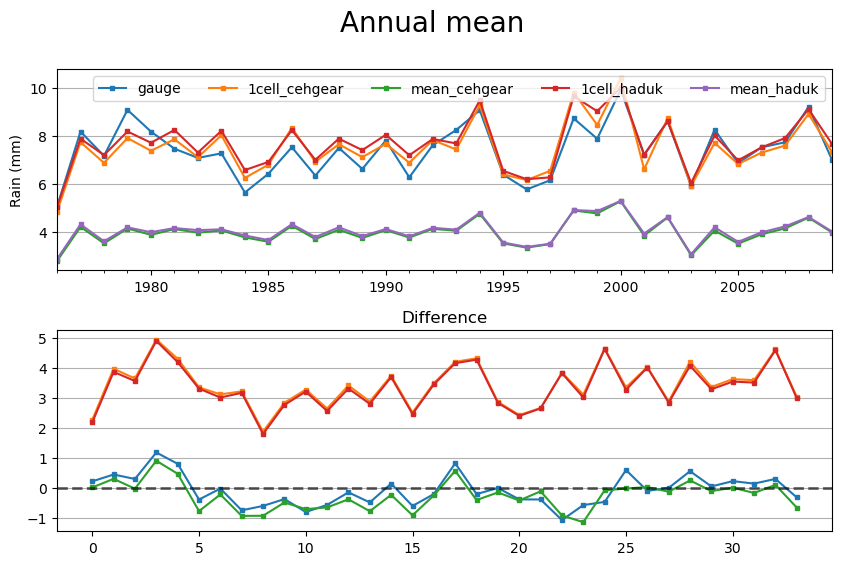

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
annual_data_dir[stat_to_examine].to_pandas().set_index('time').plot(marker='s', markersize=3, ax=axes[0])
for ind, col in enumerate(annual_data_dir[stat_to_examine].columns[2:]):
    axes[1].plot(calc_difference_from_gauge(annual_data_dir[stat_to_examine], col), marker='s', markersize=3, label=col, color=f'C{ind}')

axes[0].legend([col.split('rain_mm_')[-1] for col in annual_data_dir['mean'].columns[1:]], ncols=5)
axes[0].set_ylabel(f"Rain (mm)"); axes[0].set_xlabel('')

axes[1].set_title("Difference")
axes[1].axhline(0, color='k', linewidth=2, alpha=.6, linestyle='--')

for ax in axes:
    ax.grid(axis='y')
plt.suptitle(f"Annual {stat_to_examine}", size=20)
plt.subplots_adjust(hspace=.3)

# fig.savefig(f'../figures/annual_{stat_to_examine}_rainfall_comparison.png', bbox_inches='tight', dpi=200)

## double mass plot

In [16]:
plynlimon_rain_data_cumsum = plynlimon_rain_data.with_columns(
    pl.all().exclude("time").cum_sum()
)
plynlimon_rain_data_cumsum.tail()

time,rain_mm_gauge,rain_mm_1cell_cehgear,rain_mm_mean_cehgear,rain_mm_1cell_haduk,rain_mm_mean_haduk
datetime[μs],f64,f64,f64,f64,f64
2009-12-27 09:00:00,92069.25,93086.0,49648.325657,95371.906055,50423.206052
2009-12-28 09:00:00,92070.25,93086.3,49648.802323,95372.570642,50423.679822
2009-12-29 09:00:00,92070.25,93107.0,49660.824596,95395.955159,50436.274672
2009-12-30 09:00:00,92070.25,93120.0,49671.526717,95409.865667,50447.09588
2009-12-31 09:00:00,92070.25,93120.0,49671.629899,95409.910847,50447.210495


In [17]:
var_to_examine, data_to_examine = '1cell', 'cehgear'
x_var = f'{RAIN_COL}_1cell_haduk'
y_var = f'{RAIN_COL}_{var_to_examine}_{data_to_examine}'

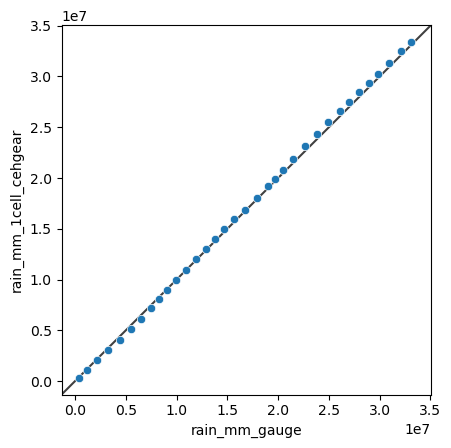

In [18]:
#  = carreg_rain_data_cumsum.group_by_dynamic('time', every='1y').agg(pl.all().sum())
data_to_plot = plynlimon_rain_data_cumsum.group_by_dynamic('time', every='12mo').agg(pl.all().sum())

fig, ax = plt.subplots(1)
sns.scatterplot(x='rain_mm_gauge', y=f'rain_mm_{var_to_examine}_{data_to_examine}', data=data_to_plot, ax=ax)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

# fig.savefig('../figures/double_mass_cehgear_gauge_annual.png', bbox_inches='tight', dpi=200)

## Look at flood events

In [19]:
## Severn-wide flood events (from: https://github.com/Thomasjkeel/FDRI-catchment-contribution-to-floods)
severn_flood_dates = ['2000-09-28', '2001-02-13', '2002-01-28', '2002-11-15', '2007-01-01', '2008-03-17','2008-11-11']
severn_flood_dates = [datetime.datetime.strptime(flood_date + ' 09:00', "%Y-%m-%d %H:%M") for flood_date in severn_flood_dates]

In [20]:
def get_date_ndays_before(one_date, ndays):
    return one_date-datetime.timedelta(days=ndays)

In [21]:
def get_data_ndays_before_flood_date(data, flood_date):
    days_before = get_date_ndays_before(flood_date, ndays=10)
    return data.filter(
        (pl.col("time") >= days_before) & (pl.col("time") <= flood_date)
    )

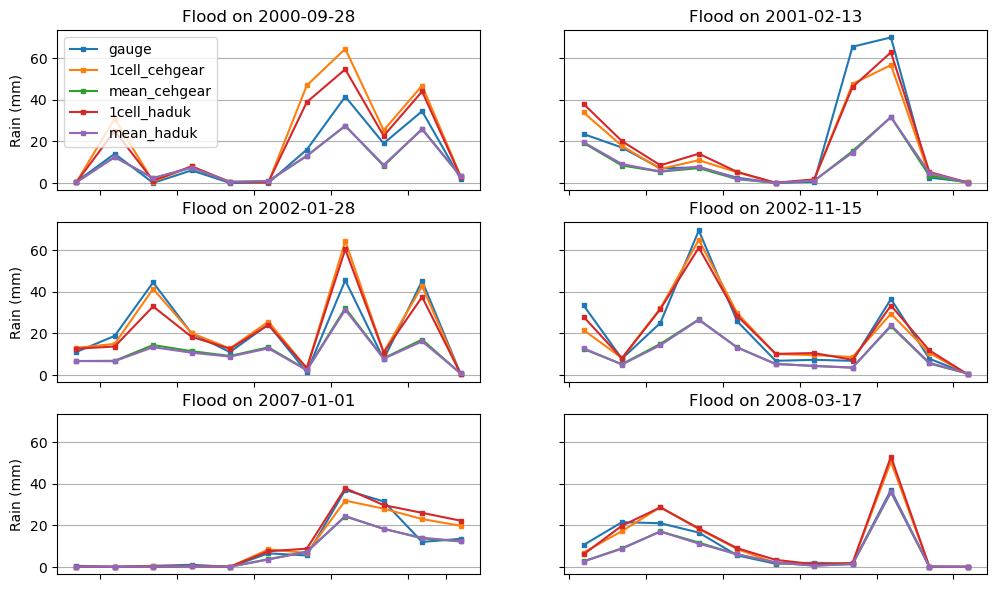

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharey=True)
for ind, ax in enumerate(axes.flatten()):
    if ind == 0:
        get_data_ndays_before_flood_date(plynlimon_rain_data, severn_flood_dates[ind]).to_pandas().set_index('time').plot(ax=ax, marker='s', markersize=3)
        ax.legend([col.split('rain_mm_')[-1] for col in annual_data_dir['mean'].columns[1:]])
    else:
        get_data_ndays_before_flood_date(plynlimon_rain_data, severn_flood_dates[ind]).to_pandas().set_index('time').plot(ax=ax, marker='s', markersize=3, legend=False)
    ax.set_title(f"Flood on {severn_flood_dates[ind].strftime('%Y-%m-%d')}")
    ax.set_xticklabels((''));
    ax.set_xlabel('')
    ax.set_ylabel('Rain (mm)')
    ax.grid(axis='y')
# fig.savefig('../figures/six_flood_comparison.png', bbox_inches='tight', dpi=200)

## Spatial variation of HADUK

In [23]:
dataset_dir = {'CEH-GEAR': ceh_plynlimon, 'HadUK-Grid': haduk_plynlimon}
dataset_to_examine = 'CEH-GEAR'

In [24]:
def plot_3by3_heatmap_mean_std(dataset, axes_row):
    dataset[RAIN_COL].mean('time').plot(cmap='Blues', ax=axes_row[0])
    axes_row[0].plot(CARREG_COORDS['Easting'], CARREG_COORDS['Northing'], 'ro')
    axes_row[0].set_title('mean')

    dataset[RAIN_COL].std('time').plot(cmap='Purples', ax=axes_row[1])
    axes_row[1].plot(CARREG_COORDS['Easting'], CARREG_COORDS['Northing'], 'ro')
    axes_row[1].set_title('stdev')

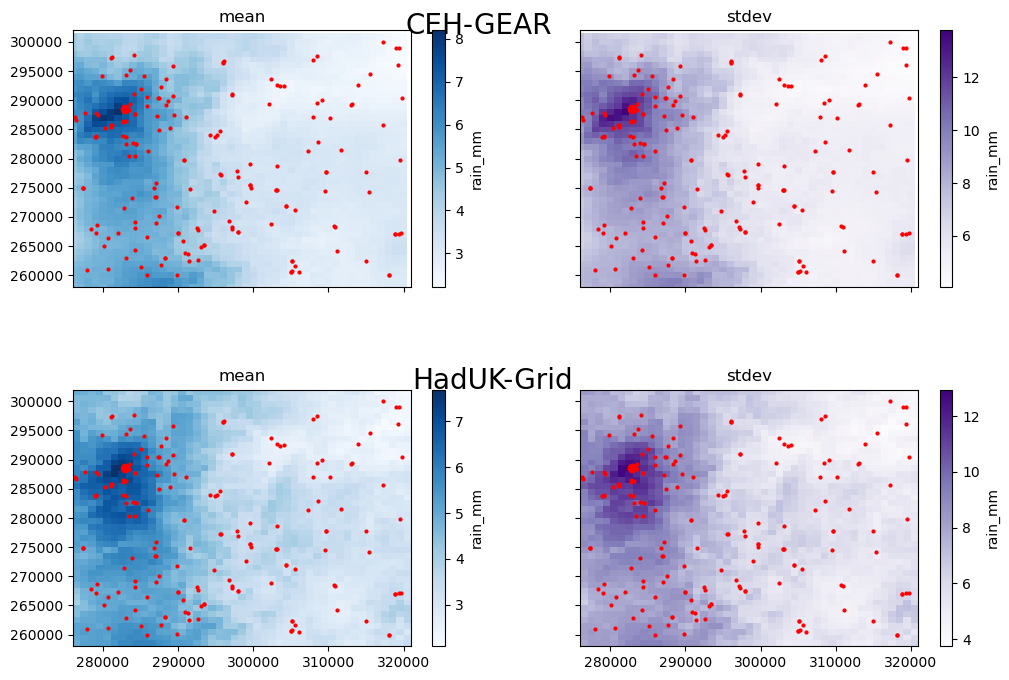

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
plot_3by3_heatmap_mean_std(dataset_dir['CEH-GEAR'], axes_row=axes[0])
plot_3by3_heatmap_mean_std(dataset_dir['HadUK-Grid'], axes_row=axes[1])

for ax in axes.flatten():
    ax.set_xlabel(''); ax.set_ylabel('')

axes[0][0].text(s='CEH-GEAR', x=dataset_dir['CEH-GEAR']['x'].max()+300,\
                              y=dataset_dir['CEH-GEAR']['y'].max()+300,\
                                size=20)

axes[1][0].text(s='HadUK-Grid', x=dataset_dir['HadUK-Grid']['projection_x_coordinate'].max()+700,\
                              y=dataset_dir['HadUK-Grid']['projection_y_coordinate'].max()+700,\
                                size=20)

for ax in axes.flatten():
  for plyn_row in plynlimon_metadata.iter_rows(named=True):
    ax.plot(plyn_row['EASTING'], plyn_row['NORTHING'], 'ro', markersize=2)

plt.subplots_adjust(hspace=.4)
# fig.savefig('../figures/ceh_vs_haduk_grid_comparison.png', bbox_inches='tight', dpi=200)